![bubble_map](data/oklahoma_bubbles.jpg)
# Oklahoma: Variations in earthquake frequency and seismic activity

The frequency of earthquakes and seismicity can change to do events other than natural causes (tectonic plate movement and stress release). For example, the state of Oklahoma began  natural gas fracking in 2010. The fracking itself, however, does not seem to change seismic behavior. It is the high pressure injection of waste-water deep into the earth that may cause the seismic activity (i.e. there may be a correletion between the injection wells as earthquakes.

We will perform a quantitative analysis of seismic activity from 1980 to mid-2017 to investigate the effect that increased injection of saline wastewater due to oil mining in Oklahoma has had on the seismicity of the region.

*image courtesy of <a href="http://www.behindenergy.com/confirmed-oklahoma-earthquakes-caused-by-fracking/?lang=en">behindenergy.com</a>

In [2]:
# import the packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import dc_stat_think as dcst


## EDA
Make a plot of all Oklahoma earthquakes between 1980 to the first half of 2017

In [14]:
path = r'/statistical_seismology/data'
# Import the seimology data for Oklahoma: oklahoma
oklahoma = pd.read_csv('data/oklahoma_earthquakes_1950-2017.csv')
#print(oklahoma.head())
from datetime import datetime as dt
oklahoma['time'] = pd.to_datetime(oklahoma['time'])
time_mags = oklahoma[(oklahoma['time'] >= '1980-01-01 01:00:00.0') & (oklahoma['mag'])]


In [15]:
# Create arrays of the times of earthquaks: time
time = pd.read_csv('data/oklahoma_decimal_dates.csv', index_col=0)
time = np.array(time['0'])

# Create an array of the magnitudes of the earthquakes: mags
mags = pd.read_csv('data/oklahoma_magnitudes.csv', index_col=0)
mags = np.array(mags['0'])
print('mags:',mags.shape)
print('time:', time.shape)

mags: (8924,)
time: (8924,)


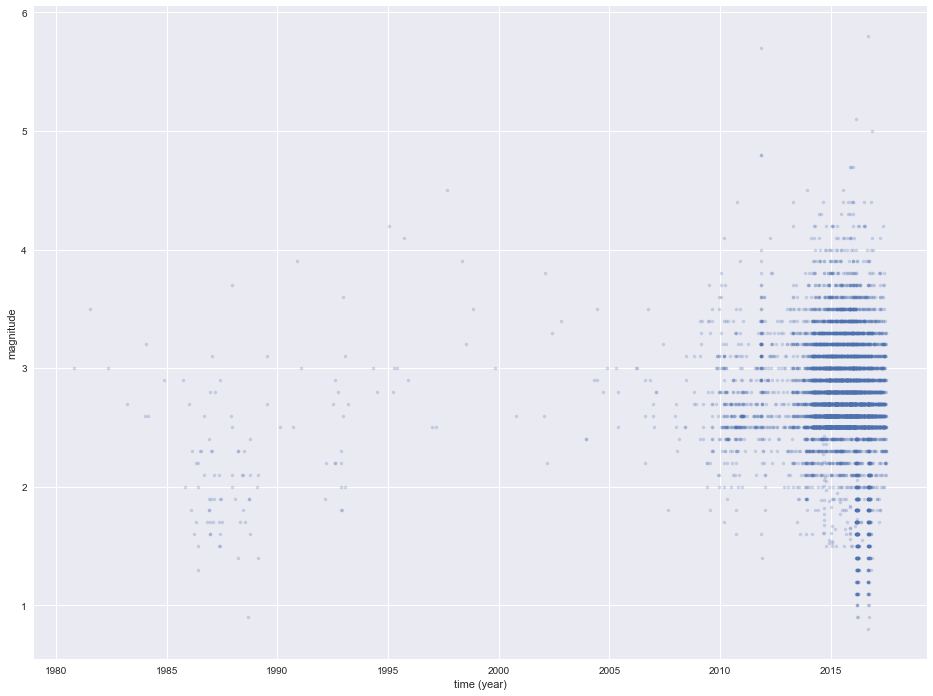

In [5]:
plt.style.use('seaborn')
plt.figure(figsize=(16, 12))
plt.plot(time, mags, marker='.', linestyle='none', alpha=0.25)
plt.xlabel('time (year)')
plt.ylabel('magnitude')
plt.show()

The plot indicates a distinct increase in the frequency and magnitueds of earthquakes after 2010.

For further analysis, we need to compare the estimate and inter-earthquake times pre-2010 and post-2010 for earthquakes  of magnitude 3 . We also need to include the 95% confidence intervals of the means.

In [16]:
# Create arrays of the pre-2010 and post-2010 time gaps between earthquakes: dt_pre, dt_post
dt_pre = pd.read_csv('data/pre2010_timegaps.csv', index_col=0)
dt_pre = np.array(dt_pre['0'])

dt_post = pd.read_csv('data/post2010_timegaps.csv', index_col=0)
dt_post = np.array(dt_post['0'])

# Compute the mean inter-earthquake times: mean_dt_pre, mean_dt_post
mean_dt_pre = np.mean(dt_pre)
mean_dt_post = np.mean(dt_post)

# Draw 10,000 bootstrap replicates of the means: bs_reps_pre, bs_reps_post
bs_reps_pre = dcst.draw_bs_reps(dt_pre, np.mean, size=10000)
bs_reps_post = dcst.draw_bs_reps(dt_post, np.mean, size=10000)

# Compute the confidence intervales: conf_int_pre, conf_int_post
conf_int_pre = np.percentile(bs_reps_pre, [2.5, 97.5])
conf_int_post = np.percentile(bs_reps_post, [2.5, 97.5])

# Print the results
print("""
1980 through 2009
mean time gap: {0:.2f} days
95% conf int [{1:.2f}, {2:.2f}] days""".format(mean_dt_pre, *conf_int_pre))

print("""
2010 through 2017
mean time gap: {0:.2f} days
95% conf int [{1:.2f}, {2:.2f}] days""".format(mean_dt_post, *conf_int_post))


1980 through 2009
mean time gap: 204.61 days
95% conf int [139.93, 277.13] days

2010 through 2017
mean time gap: 1.12 days
95% conf int [0.97, 1.29] days


There is almost a 200-fold increase in earthquakes after 2010

## Hypothesis testing

There is emperical evidence of a massive increase in earthquake frequency after wastewater injection began in Oklahoma.

H$_{0}$: Assume that the inter-earthquake times have the same mean pre and post-2010. What is the p-value associated with this hypothesis.

Test statistic: the mean of pre-2010 time gaps minus the mean of post-2010 time gaps

In [7]:
# Compute teh observed test statistic: mean_dt_diff
mean_dt_diff = mean_dt_pre - mean_dt_post

# Shift the post-2010 mean to have the same mean as the pre-2010 data: dt_post_shift
dt_post_shift = dt_post - mean_dt_post + mean_dt_pre

# Compute 10,000 bootstrap replicates of each mean of dt_pre
# and dt_post_shift: bs_reps_pre, bs_reps_post
bs_reps_pre = dcst.draw_bs_reps(dt_pre, np.mean, size=10000)
bs_reps_post = dcst.draw_bs_reps(dt_post_shift, np.mean, size=10000)

# Compute replicates difference of means: bs_reps
bs_reps = bs_reps_pre - bs_reps_post

# Compute the p-value
p_val = np.sum(bs_reps >= mean_dt_diff) / 10000
print('p = {0:.2f}'.format(p_val))

p = 0.00


0 out of 10,000 samples had a test statistic greater than what was observed.

# Earthquake magnitudes in Oklahoma

Do the post-2010 earthquakes follow the Gutenberg-Richter Law. We need to study the magnitudes of the pre and post fracking quakes

## EDA: Comparing magnitueds before and after 2010

We need to make an ECDF of earthquake magnitudes for both periods

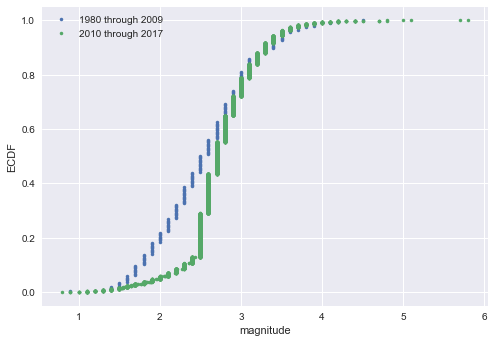

In [8]:
# Slice the magnitudes for before and after 2010: mags_pre, mags_post
mags_pre = mags[time < 2010]
mags_post = mags[time >= 2010]

# Generate the ECDFs
_ = plt.plot(*dcst.ecdf(mags_pre), marker='.', linestyle='none')
_ = plt.plot(*dcst.ecdf(mags_post), marker='.', linestyle='none')

# Label the axes and show the plot
_ = plt.xlabel('magnitude')
_ = plt.ylabel('ECDF')
plt.legend(('1980 through 2009', '2010 through 2017'), loc='upper left')
plt.show()

Both curves appear to follow the Gutenberg-Richter law but with different completeness thresholds. The difference could be attributed to improvements in sensing capabilities in more recent years.

We can safely use a completeness threshold of mt=3 and compute the b-values.

In [9]:
# Define a function that computes the b-value: b_value
def b_value(mags, mt, perc, n_reps):
    """Compute the b-value and optionally its confidence interval"""
    
    # Extract the magnitudes above the completeness threshold: m
    m = mags[mags >= mt]
    
    # Compute the b-value: b
    b = np.mean((m) - mt) * np.log(10)
    
    # Draw the bootstrap replicates: m_bs_reps
    if n_reps is None:
        return b
    else:
        m_bs_reps = dcst.draw_bs_reps(m, np.mean, size=n_reps)
        
        # Compute the b-value from the replicates: b_bs_reps
        b_bs_reps = (m_bs_reps - mt) * np.log(10)
        
        # Compute the confidence interval: conf_int
        conf_int = np.percentile(b_bs_reps, perc)
        
        return b, conf_int

In [10]:
mt=3
# Use the b_value() function to compute b-value and the
# Confidence interval for pre-2010, b_pre, conf_int_pre
b_pre, conf_int_pre = b_value(mags_pre, mt, perc=[2.5, 97.5], n_reps=10000)

# Compute the b-value and confidence interval for post-2010: b_post, conf_int_post
b_post, conf_int_post = b_value(mags_post, mt, perc=[2.5, 97.5], n_reps=10000)

# Report the results
print("""
1980 through 2009
b-value: {0:.2f}
95% conf int: [{1:.2f}, {2:.2f}]

2010 through mid-2017
b-value: {3:.2f}
95% conf_int: [{4:.2f}, {5:.2f}]
""".format(b_pre, *conf_int_pre, b_post, *conf_int_post))


1980 through 2009
b-value: 0.74
95% conf int: [0.54, 0.97]

2010 through mid-2017
b-value: 0.62
95% conf_int: [0.60, 0.65]



The confidence interval for the b-value for recent earthquakes is tighter than for earlier ones because there are many more recent eartherquakes. The confidence intervals, however, do overlap.

## Hypothesis testing
We can perform a hypothesis test to see if we might get these results if the b-values were actually the same.

For the hypothesis test, we should only include earthquakes with a magnitude $\geq$ the completeness threshold. below the threshold, we are not comparing earthquakes before and after 2010. We want to compare <i>observed</i> earthquake and we do not have a complete dataset below the completeness threshold.

A permutation test is appropriate because our hypothesis assumes both sets of magnitueds are Exponentially distributed and we are only using data for earthquakes above the completeness theshold. We are also using the G-R Law (our model) to deal with missing data.

Test statistic: the difference between the mean post-2010 magnitude and the pre-2010 magnitude is a reasonable test stat because the mean value is directly proportional to the difference in b-value.

We do not need to worry about the difference in the number of earthquakes before and after 2010 because we are only interested in summary statistics about their magnitudes.

In [11]:
# Slice out the magnitudes above the completeness threshold: mags_pre, mags_post
mags_pre = mags_pre[mags_pre >= mt]
mags_post = mags_post[mags_post >= mt]

# Compute the observed difference in mean magnitudes: diff_obs
diff_obs = np.mean(mags_post) - np.mean(mags_pre)

# Generate 10,000 permutation replicateds, use dcst.diff_of_means, as the kwarg: perm_reps
perm_reps = dcst.draw_perm_reps(mags_post, mags_pre, dcst.diff_of_means, size=10000)

# Compute and print the p-value: p_val
p_val = np.sum(perm_reps <= diff_obs) / 10000
print('p=', p_val)

p= 0.1072


A p-value that close to 0.1 suggests that the observed magnitudes are indicitive of there being no change in b-value after waste-water injection began.

## Conclusions from the analysis of earthquakes:
From 2010 to mid-2017 Oklahoma had twice as many magnitude 3+ earthquakes than the entire state of California.

The seismicity, as measured by the b-value, is comparable before and after water injection. The earthquakes became moe frequent after fracking but the magnitudes did not change much. Earthquakes are over 100 times more frequent in Oklahoma after widespread waste-water injection began.

Oklahoma has a b-value smaller than the <a href="https://github.com/btab2273/statistical_seismology/blob/master/statistical_seismology_parkfield_ca.ipynb">Parkfield region</a>. This means a randomly selected earthquake  above magnitude 3 in Oklahoma more likely than not has a smaller magnitude than an earthquake above magnitude 3 randomly selected from the Parkfield region.

In [12]:
# Save the arrays as .csv files
times_doc = pd.DataFrame(time)
mags_doc = pd.DataFrame(mags)
mags_arr = np.array(mags_doc)
times_doc.to_csv('oklahoma_decimal_dates.csv')
mags_doc.to_csv('oklahoma_magnitudes.csv')